In [ ]:
from time import time

import matplotlib.pyplot as plt

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.objectives import binary_crossentropy
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np

import os

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

def extract_data(min_faces_per_person):
    # #############################################################################
    # Download the data, if not already on disk and load it as numpy arrays

    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=0.4)

    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = lfw_people.images.shape

    # for machine learning we use the 2 data directly (as relative pixel
    # positions info is ignored by this model)
    X = lfw_people.data
    n_features = X.shape[1]

    # the label to predict is the id of the person
    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)


    # #############################################################################
    # Split into a training set and a test set using a stratified k fold

    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test, h, w, n_classes, target_names

def pca(X_train, X_test, h, w, n_components):

    # #############################################################################
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca, eigenfaces

def svm(X_train_pca, y_train, X_test_pca, y_test, n_classes, target_names):
    # #############################################################################
    # Train a SVM classification model

    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5, iid=False)
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    # #############################################################################
    # Quantitative evaluation of the model quality on the test set

    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

# Task 1.1 - Understanding SVMs and hyperparameters
## Support Vector Machine and hyperparameters
Super Vector Machine (SVM) is a machine learning model that is used both for classification and regression. 
The objective of the SVM algorithm is to find an hyperplane to separate data of distinct classes. Choose how to separate this classes is possible changing the hyperparameters of the SVM.
The main hyperparameters of a SVM are:
- **Kernel**: kernel parameters selects the type of hyperplane used to separate the data. Using ‘linear’ will use a linear hyperplane (a line in the case of 2D data). ‘rbf’ and ‘poly’ uses a non linear hyperplane.

- **C**: is the Cost parameter of the error term. It controls the trade off between smooth decision boundary and classifying training points correctly. A large value of C means you will get more intricate decision curves trying to fit in all the points. This may lead to overfitting.

- **Gamma**: defines how far the influence of a single training example reaches. If the value of Gamma is high, then the decision boundary will depend on points close to the decision boundary. If the value of Gamma is low, then far away points carry more weights than nearer points and thus the decision boundary becomes more like a straight line.

The value of gamma and C should not be very high because it leads to the overfitting and it shouldn’t be very small (underfitting). Thus we need to choose the optimal value of C and Gamma in order to get a good fit.

## Grid Search and best set of hyperparameters
Grid search is the process of performing hyperparameter tuning in order to determine the optimal hyperparameter values.

This is a python code snippet of grid search using GridSearchCV of the "sklearn" library:

In [ ]:
# Loading the Digits dataset
digits = load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

print("Finding best set of hyperparameter")
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)

The first parameter of GridSearchCV is the **estimator** that requires the kernel used for the hyperparameter tuning process (in this case an 'rbf' kernel is used).
The **param_grid** parameter requires a list of parameters and the range of values for each parameter of the specified estimator.
The GridSearchCV function search for the best set of hyperparameters performing a cross validation process.

In [ ]:
print("Fitting the classifier to the training set")
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Then is possible to use the best set of hyperparameter values, chosen in the grid search, for fitting training data.

## How the selection of features changes the results of the system
Feature extraction is a process of dimensionality reduction by which an initial set of raw data is reduced to more manageable groups for processing. In this lecture it is used the Principal Component Analysis (PCA).
### Number of components
Using the PCA approach, is important to estimate how many components are needed to describe the data. This can be done by looking at the cumulative variance of these components to see how much of the data information the projection is preserving. In our face recognition example we have more than 3.000 components, looking at the cumulative variance of the first 150 components we see that these 150 components account for just over 90% of the variance [1]. This means that using these 150 components, we would recover most of the essential characteristics of the data.

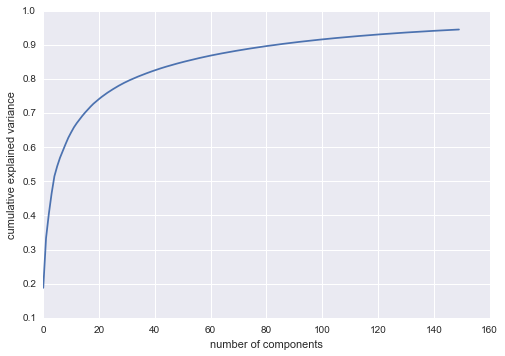 image from *Python Data Science Handbook* [1]




### Apply the PCA on the whole dataset containing images of many more persons
In our example we take from the dataset the picture of the persons for which we have more than 70 faces. Decreasing this parameter, will lead to have a more large dataset with more person, but for each person we have few images. This leads to a decreasing accurance in the face recognition process.

### Results
Below is possible to execute the lecture example with different **#n_components** and **#min_face_per_person**. Looking at the result grids is possible to see how decreasing the #components and the #min_face_per_person (incresing number of faces) decreas the face recognition accurance. Decreasing the #min_face_per_person we have more images for the training process but for the person for which we have few faces, the prediction is less accurate.

#### **n_components=150** **min_faces_per_person=70**

In [ ]:
print("#n_components = 150")
print("#min_faces_per_person = 70")
n_components = 150
min_faces_per_person = 70
X_train, X_test, y_train, y_test, h, w, n_classes, target_names = extract_data(min_faces_per_person)
X_train_pca, X_test_pca, eigenfaces = pca(X_train, X_test, h, w, n_components)
svm(X_train_pca, y_train, X_test_pca, y_test, n_classes, target_names)

#### **n_components=150** **min_faces_per_person=30**

In [ ]:
print("#n_components = 150")
print("#min_faces_per_person = 30")
n_components = 150
min_faces_per_person = 30
X_train, X_test, y_train, y_test, h, w, n_classes, target_names = extract_data(min_faces_per_person)
X_train_pca, X_test_pca, eigenfaces = pca(X_train, X_test, h, w, n_components)
svm(X_train_pca, y_train, X_test_pca, y_test, n_classes, target_names)

#### **n_components=30** **min_faces_per_person=70**

In [ ]:
print("#n_components = 30")
print("#min_faces_per_person = 70")
n_components = 30
min_faces_per_person = 70
X_train, X_test, y_train, y_test, h, w, n_classes, target_names = extract_data(min_faces_per_person)
X_train_pca, X_test_pca, eigenfaces = pca(X_train, X_test, h, w, n_components)
svm(X_train_pca, y_train, X_test_pca, y_test, n_classes, target_names)

#### **n_components=75** **min_faces_per_person=45**

In [ ]:
print("#n_components = 75")
print("#min_faces_per_person = 45")
n_components = 75
min_faces_per_person = 45
X_train, X_test, y_train, y_test, h, w, n_classes, target_names = extract_data(min_faces_per_person)
X_train_pca, X_test_pca, eigenfaces = pca(X_train, X_test, h, w, n_components)
svm(X_train_pca, y_train, X_test_pca, y_test, n_classes, target_names)

# Task 1.2 - Learning Features as an Input for Classification
## Autoencoder ( 2 layers)
The feature extraction part of the approach (PCA) should be replaced. I'll use the **latent space** of a 2 layers  autoencoder trained in an unsupervised fashion.

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

x = lfw_people.data
y = lfw_people.target

x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(x, y, test_size=0.25, random_state=42)
n_samples, h, w = lfw_people.images.shape

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

original_dim = h * w

idx = np.arange(x_train_orig.shape[0])
np.random.shuffle(idx)
x_train = np.zeros(shape=(x_train_orig.shape[0], x_train_orig.shape[1]))
y_train = np.zeros(shape=(x_train_orig.shape[0],))
for i in range(0, x_train_orig.shape[0]):
    x_train[i] = x_train_orig[ idx[i] ]
    y_train[i] = y_train_orig[ idx[i] ]

idx = np.arange(x_test_orig.shape[0])
np.random.shuffle(idx)
x_test = np.zeros(shape=(x_test_orig.shape[0], x_test_orig.shape[1]))
y_test = np.zeros(shape=(x_test_orig.shape[0],))
for i in range(0, x_test_orig.shape[0]):
    x_test[i] = x_test_orig[ idx[i] ]
    y_test[i] = y_test_orig[ idx[i] ]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

intermediate_dim = 512
batch_size = 100
latent_dim = 150
epochs = 50

inputs = Input(shape=(original_dim,))

latent_space = Dense(latent_dim, activation='relu')(input)

# encoder, from inputs to latent space
encoder = Model(inputs, latent_space, name="encoder")
encoder.summary()

output = Dense(original_dim, activation='sigmoid')(latent_space)

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

# end-to-end autoencoder
vae = Model(inputs, output, name="vae")
vae.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])
vae.summary()

print("Training the autoencoder to the training set")
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


x_train_latentspace = encoder.predict(x_train, batch_size)
x_test_latentspace = encoder.predict(x_test, batch_size)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 5, 10, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(x_train_latentspace, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(x_test_latentspace)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

## Variational autoencoder
The feature extraction part of the approach (PCA) should be replaced. I'll use the **latent space** of a variational autoencoder trained in an unsupervised fashion. 

In [ ]:
#Extract data from dataset
min_faces_per_person = 70
x_train, x_test, y_train, y_test, h, w, n_classes, target_names = extract_data(min_faces_per_person)

#Prepare dataset
original_dim = h * w
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#Layers dimension
#Latent space dimension is 150 as request from the exercise
intermediate_dim = 512
latent_dim = 150
batch_size = 128
epochs = 50

Instantiate the **encoder** network:

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_sigma])

# encoder, from inputs to latent space
encoder = Model(inputs, [z_mean, z_log_sigma, z], name="encoder")
encoder.summary()

Instantiate the **decoder** network:

In [ ]:
encoded_input = Input(shape=(latent_dim,))
decoder_h = Dense(intermediate_dim, activation='relu')(encoded_input)
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)

# decoder, from latent space to outputs
decoder = Model(encoded_input, decoder_mean, name="decoder")
decoder.summary()

Instantiate the **autoencoder**:

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

outputs = decoder(encoder(inputs)[2])

# end-to-end autoencoder
vae = Model(inputs, outputs, name="vae")
vae.compile(optimizer='rmsprop', loss=vae_loss, metrics=["accuracy"])
vae.summary()

Train the **autoencoder**:

In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

We now have a trained network. We'll use the encoder network as the feature extracion part. Last, train the Support Vector Machine with the provided features.

In [ ]:
x_train_latentspace, _, _ = encoder.predict(x_train, batch_size)
x_test_latentspace, _, _ = encoder.predict(x_test, batch_size)

svm(x_train_latentspace, y_train, x_test_latentspace, y_test, n_classes, target_names)

## Compare the results to the original approach 
The results obtained using the encoder network are not the expected one. Every faces is associated to Hugo Chavez. This is a bad result, probably due to an incorrect implementation of the autoencoder. It seems the network is not trained well but I can't find out where is the problem in my code.